In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 253 kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
# The following code ensures that all of the project members are able to mount the notebook to their specific drive and retrieve any directory-specific data.

# Calvin's directory
# %cd /content/drive/MyDrive/2022-23/CS 182/Project 
# Alec's directory
# %cd /content/drive/MyDrive/182/fa22-cs182-proj
# Anthony's directory
# %cd /content/drive/MyDrive/
# Joey's directory 
# %cd /content/drive/MyDrive/fa22-cs182-proj 

%cd /content/drive/MyDrive # Comment out if you are one of the project members, leave it in if you are staff


Mounted at /content/drive/
/content/drive/MyDrive/182/fa22-cs182-proj
[Errno 2] No such file or directory: '/content/drive/MyDrive/fa22-cs182-proj'
/content/drive/MyDrive/182/fa22-cs182-proj


In [ ]:
# To get the data from the other notebook, copy the data folder into your drive
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import trange, tqdm

import einops
import pickle
import os

torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
root_folder = colab_root_folder = os.getcwd()

In [ ]:
data = np.load("small_data_0.npy")
print(data.shape)


(2500, 9, 32, 32, 2)


In [ ]:
# Stealing some functions from hw9 to use here.
def patchify(images, patch_size=4):
    """Splitting simulation frames into patches.
    Modified patchify to stack image sequences along the width axis.
    """
    width_stacked_sequences = einops.rearrange(
        images,
        'b s h w c -> b h (w s) c',
    )
    # print("wss", width_stacked_sequences.shape)
    return einops.rearrange(
        width_stacked_sequences,
        'b (h p1) (w p2) c -> b (h w) (c p1 p2)',
        p1=patch_size,
        p2=patch_size)

def unpatchify(patches, patch_size=4, sequence_length=9, original_image_length=8):
    """ Combining patches into simulation frames
    Modified unpatchify from hw9 to collapse a single image into its animation frames again.
    """
    width_stacked_sequences = einops.rearrange(
        patches,
        'b (h w) (c p1 p2) -> b (h p1) (w p2) c',
        p1=patch_size,
        p2=patch_size,
        h=original_image_length,
        c=2,
    )
    # print("wss", width_stacked_sequences.shape)
    return einops.rearrange(
        width_stacked_sequences,
        'b h (w s) c -> b s h w c',
        s=sequence_length
    )


In [ ]:
class Transformer(nn.Module):
    """Transformer Encoder 
    Args:
        embedding_dim: dimension of embedding
        n_heads: number of attention heads
        n_layers: number of attention layers
        feedforward_dim: hidden dimension of MLP layer
    Returns:
        Transformer embedding of input
    """
    def __init__(self, embedding_dim=256, n_heads=4, n_layers=4, feedforward_dim=1024):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.feedforward_dim = feedforward_dim
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embedding_dim,
                nhead=self.n_heads,
                dim_feedforward=self.feedforward_dim,
                activation=F.gelu,
                batch_first=True,
                dropout=0.0,
            ),
            num_layers=n_layers,
        )

    def forward(self, x):
        return self.transformer(x)
        

In [ ]:
def index_sequence(x, ids):
    """Index tensor (x) with indices given by ids
    Args:
        x: input sequence tensor, can be 2D (batch x length) or 3D (batch x length x feature)
        ids: 2D indices (batch x length) for re-indexing the sequence tensor
    """
    if len(x.shape) == 3:
        ids = ids.unsqueeze(-1).expand(-1, -1, x.shape[-1])
    return torch.take_along_dim(x, ids, dim=1)

def random_masking(x, keep_length, ids_shuffle):
    """Apply random masking on input tensor
    Args:
        x: input patches (batch x length x feature)
        keep_length: length of unmasked patches
        ids_shuffle: random indices for shuffling the input sequence. This is an
            array of size (batch x length) where each row is a permutation of 
            [0, 1, ..., length-1]. We will pass this array to index_sequence function
            to chooose the unmasked patches.
        
    Returns:
        kept: unmasked part of x: (batch x keep_length x feature)
        mask: a 2D (batch x length) mask tensor of 0s and 1s indicated which
            part of x is masked out. The value 0 indicates not masked and 1
            indicates masked.
        ids_restore: indices to restore x. This is an array of size (batch x length).
            If we take the kept part and masked
            part of x, concatentate them together and index it with ids_restore,
            we should get x back. (Hint: try using torch.argsort on the shuffle indices)
    """
    batch, length, dim = x.shape
    ids_restore = torch.argsort(ids_shuffle, dim=1)
    kept = index_sequence(x, ids_shuffle[:, :keep_length])
    mask = x.new_ones([batch, length])
    mask[:, :keep_length] = 0.0
    mask = index_sequence(mask, ids_restore)
    # print(kept.shape)
    # print(x.shape)
    return kept, mask, ids_restore

def restore_masked(kept_x, masked_x, ids_restore):
    """Restore masked patches
    Args:
        kept_x: unmasked patches: (batch x keep_length x feature)
        masked_x: masked patches: (batch x (length - keep_length) x feature)
        ids_restore: indices to restore x: (batch x length)
    Returns:
        restored patches
    Hint: use index_sequence function on an array with the kept and masked tokens concatenated
    """
    return index_sequence(
        torch.cat([kept_x, masked_x], dim=1),
        ids_restore
    )

In [ ]:
class MaskedAutoEncoder(nn.Module):
    """MAE Encoder
    Args:
        encoder: vit encoder
        decoder: vit decoder
        encoder_embedding_dim: embedding size of encoder
        decoder_embedding_dim: embedding size of decoder
        patch_size: image patch size
        num_patches_width: number of patches along the width-axis
        num_patches_height: number of patches along the height_axis
        num_frames: number of frames in the simulation
        mask_ratio: percentage of masked patches
    """
    def __init__(self, encoder, decoder, encoder_embedding_dim=256, 
                 decoder_embedding_dim=128, patch_size=4, 
                 num_patches_height=8, num_patches_width=72,
                 mask_ratio=0.2, num_frames = 9):
        super().__init__()
        self.encoder_embedding_dim = encoder_embedding_dim
        self.decoder_embedding_dim = decoder_embedding_dim
        self.patch_size = patch_size
        self.num_patches_height = num_patches_height
        self.num_patches_width = num_patches_width
        self.mask_ratio = mask_ratio

        self.masked_length = int(num_patches_height * num_patches_width * mask_ratio)
        self.keep_length = num_patches_height * num_patches_width - self.masked_length

        self.encoder = encoder
        self.decoder = decoder

        self.encoder_input_projection = nn.Linear(patch_size * patch_size * 2, encoder_embedding_dim)
        self.decoder_input_projection = nn.Linear(encoder_embedding_dim, decoder_embedding_dim)
        self.decoder_output_projection = nn.Linear(decoder_embedding_dim, patch_size * patch_size * 2)
        self.cls_token = nn.Parameter(torch.randn(1, 1, encoder_embedding_dim) * 0.02)
        self.encoder_position_encoding = nn.Parameter(torch.randn(1, num_patches_height * num_patches_width, encoder_embedding_dim) * 0.02)
        self.decoder_position_encoding = nn.Parameter(torch.randn(1, num_patches_height * num_patches_width, decoder_embedding_dim) * 0.02)
        self.masked_tokens = nn.Parameter(torch.randn(1, 1, decoder_embedding_dim) * 0.02)

    def forward_encoder(self, images, ids_shuffle=None):
        """Encode input images
        You should implement the following steps
        (1) patchify images into patches
        (2) linear projection
        (3) add position encoding
        (4) mask out some of the patches
        (5) concatenate cls_token and patches embedding and pass it to vit encoder
        """
        batch_size = images.shape[0]
        if ids_shuffle is None:
            ids_shuffle = torch.argsort(
                torch.rand(
                    (batch_size, self.num_patches_height * self.num_patches_width),
                    device=images.device
                ),
                dim=1
            )

        patches = patchify(images, self.patch_size)
        # print(patches.shape)
        patch_embeddings = self.encoder_input_projection(patches) + self.encoder_position_encoding
        kept, mask, ids_restore = random_masking(patch_embeddings, self.keep_length, ids_shuffle)
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        embeddings = torch.cat([cls_token, kept], dim=1)
        return self.encoder(embeddings), mask, ids_restore

    def forward_decoder(self, encoder_embeddings, ids_restore):
        """Decode encoder embeddings
        You should implement the following steps
        (1) linear projection of encoder embeddings
        (2) restore sequence from masked_patches and encoder predictions
            We need our decoder output to have the same number of tokens as the original patched input, 
            but our encoder currently is missing some tokens that we masked out. We need to add some dummy 
            tokens back to our embedded tokens so when our decoder outputs, it has the correct number of 
            tokens that can be interpreted as sequential patches of output image.
            During this step, you should remove the CLS token from the sequence.
        (3) add position encoding
        (3) re-concatenate/use CLS token and decode using ViT decoder 
        (4) projection to predict image patches
        """
        #1
        batch_size = encoder_embeddings.shape[0]
        decoder_embeddings = self.decoder_input_projection(encoder_embeddings)
        #2
        cls_token = decoder_embeddings[:, :1, :]
        decoder_embeddings = decoder_embeddings[:, 1:, :]
        masked_patches = self.masked_tokens.expand(batch_size, self.masked_length, -1)
        decoder_embeddings = restore_masked(decoder_embeddings, masked_patches, ids_restore)
        # 3
        decoder_embeddings = decoder_embeddings + self.decoder_position_encoding
        # 4
        decoder_embeddings = torch.cat([cls_token, decoder_embeddings], dim=1)
        decoder_output = self.decoder(decoder_embeddings)[:, 1:, :]
        return self.decoder_output_projection(decoder_output)

    def forward(self, images):
        encoder_output, mask, ids_restore = self.forward_encoder(images)
        decoder_output = self.forward_decoder(encoder_output, ids_restore)
        return decoder_output, mask

    def forward_encoder_representation(self, images):
        """Encode images without applying random masking to get representation
        of input images. 

        You should implement splitting images into patches, re-concatenate/use CLS token,
        and encoding with ViT encoder.
        """
        batch_size = images.shape[0]
        patches = patchify(images, self.patch_size)
        patch_embeddings = self.encoder_input_projection(patches)
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        embeddings = patch_embeddings + self.encoder_position_encoding
        embeddings = torch.cat([cls_token, embeddings], dim=1)
        return self.encoder(embeddings)
  

In [ ]:
batch_size = 4
print(data.shape)
patched_data = torch.tensor(patchify(data))
print(patched_data.shape)
restored_data = unpatchify(patched_data)
print(restored_data.shape)

train_y = torch.zeros((data.shape[0], 1))
print(train_y.shape)
trainset = torch.utils.data.TensorDataset(torch.tensor(data).float(), train_y)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

(2500, 9, 32, 32, 2)
torch.Size([2500, 576, 32])
torch.Size([2500, 9, 32, 32, 2])
torch.Size([2500, 1])


In [ ]:
model = MaskedAutoEncoder(
    Transformer(embedding_dim=256, n_layers=4),
    Transformer(embedding_dim=128, n_layers=2),
)
# Move the model to GPU
model.to(torch_device)
# Create optimizer

optimizer = optim.AdamW(model.parameters(), lr=1e-6, betas=(0.9, 0.95), weight_decay=0.0)

total_steps = 0
num_epochs = 10
train_logfreq = 100

losses = []

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    data_iterator = tqdm(trainloader)
    for x, y in data_iterator:
        total_steps += 1
        x = x.to(torch_device)
        image_patches = patchify(x)
        # print(x.shape)
        # print(image_patches.shape)
        predicted_patches, mask = model(x)
        # print(predicted_patches.shape)
        loss = torch.sum(torch.mean(torch.square(image_patches - predicted_patches), dim=-1) * mask) / mask.sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item())
        if total_steps % train_logfreq == 0:
            losses.append(loss.item())

    # Periodically save model
    torch.save(model.state_dict(), os.path.join(root_folder, "mae_pretrained.pt"))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

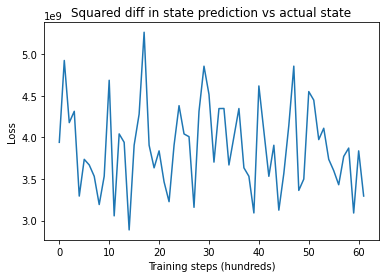

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.title('Squared diff in state prediction vs actual state')
plt.ylabel('Loss')
plt.xlabel('Training steps (hundreds)')
plt.show()